In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
%matplotlib inline

## Getting the columns and building a dtype dictionary

In [4]:
columns = pd.read_csv('/Volumes/thesis-data/main.csv', nrows=1).columns

In [5]:
x = {'ADM_MET': 'object', 'DIS_MET': 'object', 'ADM_SOU': 'object',
    'MAIN_SPEC': 'object', 'NON_NHS_FLAG': 'category', 
    'OPCS_12': 'object', 'OPCS_13': 'object', 'DIAG_NO': 'int', 
    'PROC_NO': 'int', 'Age': 'int', 'DayofMainProc': 'category', 
    'SEX': 'object', 'consultant': 'object', 'end_ward': 'object', 
    'pasid': 'object', 'practice_code': 'object', 'procedure_code': 'category', 
    'site1': 'category', 'south_north': 'object', 'start_ward': 'object', 
    'end_ward': 'object', '100x': 'category', '10x': 'category', '5x': 'category', 
    '2x': 'category', 'ACTIVITY': 'category', 'C.DIFF': 'category', 
    'MRSA': 'category', 'Obese': 'category', 'NON_NHS_FLG': 'category', 
    'SPECIALTY': 'category', 'ACUITY': 'category', 'SS_CODE': 'object', 
    'WIP_FLG': 'object', 'SPELL_FLG': 'object', 'INTERNAL_ID': 'object'}

primsec = [col for col in columns if col.endswith('Prim') or col.endswith('Sec') or col.endswith('.1')]
y = {col: 'category' for col in primsec}

dtype_dict = {**x, **y}
dates = ['Bench_Period', 'Period', 'ADMDATE', 'DISCDATE', 'EPISODE_ST', 'EPISODE_END', 'procedure_date_dt']

## Reading in the whole dataset

In [6]:
%%time
chunksize = 300000
chunks = []
for chunk in pd.read_csv('/Volumes/thesis-data/main.csv', 
                         parse_dates=dates, dtype=dtype_dict, 
                         chunksize=chunksize):
    chunks.append(chunk)

data = pd.concat(chunks)

CPU times: user 3min 33s, sys: 8.23 s, total: 3min 41s
Wall time: 3min 42s


#### We have 2,447,475 episodes described by 259 attributes of which there are 865,430 individual patients and separate spells:

In [7]:
data.shape, data.PATIENT_ID.nunique(), data.SPELL_ID.nunique()

((2447475, 259), 865430, 1946597)

#### Note that in this dataset there are a number of categorical attributes with a large range of values. For instance, we have:
- 1082 GP practices
- 1468 HRGs (Healthcare Resource Groups)
- 7747 primary diagnoses (ICD10)
- 4751 primary procedures (OPCS10)

In [7]:
data.practice_code.nunique(), data.HRG.nunique(), data.ICD10.nunique(), data.OPCS4.nunique()

(1082, 1468, 7747, 4751)

#### So, we will reduce our dataset's attributes to include:
- personal identifiers (IDs, sex, age, origin, etc.)
- cost components
- non-specific clinical attributes (number of diagnoses, length of stay, HRG subchapter, obesity, admission method, elective/non-elective, etc.)

#### We will also remove specific clinical attributes such as:
- diagnosis codes
- particular HRGs
- procedure codes
- comorbidities

From this reduced dataset, we will carry out some initial descriptive data analysis that can be used for some elementary statistical inference later on. Obviously, work is needed to reduce the number of categorical values by means of clustering or in the case of GP practices, say, we could group them by their locality after they are decoded. This grouping would also make for a nice collection of graphs in the future using `geopandas`.

In [8]:
HRG_OPCS_ICD_Prog_cols = ['HRG'] + [col for col in columns if col.startswith('OPCS_') or col.startswith('ICD_') or col.startswith('Programme')]
severity = ['2x', '5x', '10x', '100x']

undesired_cols = ['LOAD_DATE'] + HRG_OPCS_ICD_Prog_cols + severity + primsec

df = data[[col for col in columns if col not in undesired_cols]]

In [38]:
primsec

['AMIPrim',
 'AMISec',
 'AsthmaPrim',
 'AsthmaSec',
 'BldPrim',
 'BldSec',
 'BurnsPrim',
 'BurnsSec',
 'CHDPrim',
 'CHDSec',
 'CHFPrim',
 'CHFSec',
 'CTDPrim',
 'CTDSec',
 'CVAPrim',
 'CVASec',
 'CanPrim',
 'CanSec',
 'CancerPrim',
 'CancerSec',
 'CerebrovascularPrim',
 'CerebrovascularSec',
 'ChronPainPrim',
 'ChronPainSec',
 'DemPrim',
 'DemSec',
 'DentPrim',
 'DentSec',
 'DiabPrim',
 'DiabSec',
 'DiabcompPrim',
 'DiabcompSec',
 'DiabetesPrim',
 'DiabetesSec',
 'EndocPrim',
 'EndocSec',
 'GUPrim',
 'GUSec',
 'GastroPrim',
 'GastroSec',
 'GenTctPrim',
 'GenTctSec',
 'HIVPrim',
 'HIVPrim.1',
 'HIVSec',
 'HIVSec.1',
 'HearPrim',
 'HearSec',
 'InfPrim',
 'InfSec',
 'LDPrim',
 'LDPrim.1',
 'LDSec',
 'LDSec.1',
 'MSKPrim',
 'MSKSec',
 'MatRepPrim',
 'MatRepSec',
 'MentalHealthPrim',
 'MentalHealthSec',
 'MetCancPrim',
 'MetCancSec',
 'NeoNatPrim',
 'NeoNatSec',
 'NeuroPrim',
 'NeuroSec',
 'ObstructiveAirwaysDiseasePrim',
 'ObstructiveAirwaysDiseaseSec',
 'OthCircPrim',
 'OthCircSec',
 'Oth

In [37]:
len(primsec)

104

In [9]:
pd.set_option('display.max_columns', 125)

In [9]:
costs = ['COST', 'NetCost', 'DIRECT', 'INDIRECT', 'OVERHEAD', 'CRIT', 
         'EMER', 'IMG', 'MED', 'NCI', 'OPTH', 'OTH', 'OUTP', 'PATH', 
         'PHAR', 'PROS', 'SPS', 'THER', 'WARD', 'BLD', 'ENDO', 'OCLST', 
         'OVH', 'RADTH', 'HCD', 'CNST', 'INCOME', 'DRUG', 'SECC']

In [10]:
len(costs)

29

In [34]:
df.groupby('PATIENT_ID')['LOS'].mean().describe(percentiles=[.5, .75, .8, .9, .95, .99, .999, .9999])

count     865430.000000
mean           2.447014
std            5.376832
min            1.000000
50%            1.000000
75%            2.000000
80%            2.750000
90%            5.000000
95%            7.897632
99%           19.500000
99.9%         57.000000
99.99%       146.000000
max         1830.000000
Name: LOS, dtype: float64

In [25]:
num_df = df[[col for col in df.columns if df[col].dtype in [float, int]]]
num_df

,Age,BLD,CC_LOS,CNST,COST,CRIT,DC,DIAG_NO,DIAG_NO_WEI,DIRECT,DIS_DES,DOM_LEVEL,DRUG,DRUG_CHEMO,EL,EMER,ENDO,ENDO_TIME,HCD,IMG,IMG_MED,IMG_OTH,INCOME,INDIRECT,LOS,MED,MFF,MFFT_Delay_Days,NCI,NE,NID,NPCA,NetCost,OCLST,OPTH,OTH,OTH_MED,OTH_OTH,OUTP,OVERHEAD,OVH,PATH,PATH_MED,PATH_OTH,PHAR,PROC_NO,PROC_NO_WEI,PROS,RADTH,REF_TYPE,SECC,SIGN_SYMPTOM,SPELL_EBD,SPELL_EBD_COST,SPELL_LOS,SPELL_WARD,SPS,SSC,THER,TH_TIME,WARD
0,67,0.00,0.0,0.0,593.69,0.00,0.0,7,36.0,NaN,19.0,NaN,0.00,0.0,0.0,0.0,0.00,NaN,5.61,278.31,0.0,0.00,NaN,NaN,4.0,40.13,1.0,NaN,-9.31,1.0,34.29,0.0,593.69,0.00,0.00,0.00,0.0,0.00,0.0,NaN,154.72,89.86,0.0,0.00,0.08,2,2.0,0.00,0.0,NaN,0.00,1.0,0.0,0.0,7.0,0.00,0.00,0.0,0.00,0.0,0.00
1,90,0.00,0.0,0.0,255.05,0.00,0.0,4,21.0,NaN,19.0,NaN,0.00,0.0,0.0,0.0,0.00,NaN,5.61,0.00,0.0,0.00,NaN,NaN,1.0,12.63,1.0,NaN,-9.31,1.0,34.29,0.0,255.05,0.00,0.00,0.00,0.0,0.00,0.0,NaN,132.56,0.00,0.0,0.00,0.08,0,0.0,0.00,0.0,NaN,79.19,1.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00
2,23,0.00,0.0,0.0,1372.17,0.00,1.0,2,8.0,NaN,19.0,NaN,21.48,0.0,0.0,0.0,0.00,NaN,5.61,0.00,0.0,0.00,NaN,NaN,1.0,454.38,1.0,NaN,-51.15,0.0,50.65,0.0,1372.17,0.00,679.95,0.00,0.0,0.00,0.0,NaN,204.73,0.00,0.0,0.00,0.08,7,29.0,0.00,0.0,NaN,0.00,0.0,0.0,0.0,1.0,6.44,0.00,0.0,0.00,47.0,6.44
3,87,0.00,0.0,0.0,592.16,0.00,0.0,2,12.0,NaN,99.0,NaN,104.29,0.0,0.0,0.0,0.00,NaN,5.61,178.56,0.0,0.00,NaN,NaN,1.0,41.24,1.0,NaN,-9.31,1.0,34.29,0.0,592.16,0.00,0.00,0.00,0.0,0.00,0.0,NaN,83.33,0.00,0.0,0.00,0.08,3,2.0,0.00,0.0,NaN,0.00,0.0,0.0,0.0,7.0,1078.46,0.00,0.0,0.00,0.0,154.07
4,1,0.00,0.0,0.0,728.51,0.00,0.0,1,6.0,NaN,19.0,NaN,10.29,0.0,0.0,0.0,0.00,NaN,5.61,267.85,0.0,0.00,NaN,NaN,1.0,147.53,1.0,NaN,-32.17,1.0,14.50,0.0,728.51,0.00,0.00,0.00,0.0,0.00,0.0,NaN,102.46,0.00,0.0,0.00,0.08,0,0.0,0.00,0.0,NaN,0.00,1.0,0.0,0.0,1.0,212.36,0.00,0.0,0.00,0.0,212.36
5,2,0.00,0.0,0.0,483.90,0.00,0.0,1,3.0,NaN,19.0,NaN,33.53,0.0,0.0,0.0,0.00,NaN,5.61,0.00,0.0,0.00,NaN,NaN,1.0,147.53,1.0,NaN,-32.17,1.0,14.50,0.0,483.90,0.00,0.00,0.00,0.0,0.00,0.0,NaN,102.46,0.00,0.0,0.00,0.08,0,0.0,0.00,0.0,NaN,0.00,0.0,0.0,0.0,1.0,212.36,0.00,0.0,0.00,0.0,212.36
6,75,0.00,0.0,0.0,811.65,0.00,1.0,3,17.0,NaN,19.0,NaN,30.02,0.0,0.0,0.0,168.23,NaN,5.61,0.00,0.0,0.00,NaN,NaN,1.0,93.44,1.0,NaN,-11.94,0.0,23.95,0.0,811.65,0.00,85.07,0.00,0.0,0.00,0.0,NaN,198.93,0.00,0.0,0.00,0.08,2,7.0,0.00,0.0,NaN,0.00,1.0,0.0,0.0,1.0,171.41,0.00,0.0,46.85,8.0,171.41
7,8,0.00,0.0,0.0,563.88,0.00,0.0,1,6.0,NaN,19.0,NaN,10.29,0.0,0.0,0.0,0.00,NaN,5.61,0.00,0.0,0.00,NaN,NaN,1.0,279.18,1.0,NaN,-32.17,1.0,14.50,0.0,563.88,0.00,0.00,0.00,0.0,0.00,0.0,NaN,135.11,0.00,0.0,0.00,0.08,0,0.0,0.00,0.0,NaN,0.00,1.0,0.0,0.0,1.0,151.28,0.00,0.0,0.00,0.0,151.28
8,77,0.00,0.0,0.0,1130.62,0.00,0.0,8,26.0,NaN,19.0,NaN,9.22,0.0,0.0,0.0,0.00,NaN,5.61,69.58,0.0,0.00,NaN,NaN,1.0,773.70,1.0,NaN,-22.69,1.0,38.98,0.0,1130.62,0.00,0.00,0.00,0.0,0.00,0.0,NaN,241.14,5.21,0.0,0.00,0.08,0,0.0,0.00,0.0,NaN,0.00,0.0,0.0,0.0,1.0,9.79,0.00,0.0,0.00,0.0,9.79
9,21,0.00,0.0,0.0,427.16,0.00,0.0,2,5.0,NaN,19.0,NaN,22.33,0.0,0.0,0.0,0.00,NaN,5.61,89.28,0.0,0.00,NaN,NaN,1.0,43.58,1.0,NaN,-22.69,1.0,38.98,0.0,427.16,0.00,0.00,0.00,0.0,0.00,0.0,NaN,98.56,0.00,0.0,0.00,0.08,0,0.0,0.00,0.0,NaN,0.00,1.0,0.0,0.0,1.0,151.43,0.00,0.0,0.00,0.0,151.43


In [29]:
costs_df = df[costs]

In [30]:
costs_df.describe()

,COST,NetCost,DIRECT,INDIRECT,OVERHEAD,CRIT,EMER,IMG,MED,NCI,OPTH,OTH,OUTP,PATH,PHAR,PROS,SPS,THER,WARD,BLD,ENDO,OCLST,OVH,RADTH,HCD,CNST,INCOME,DRUG,SECC
count,2.447475e+06,2.447475e+06,223122.0,223122.0,223122.0,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,2.447475e+06,223122.0,2.447475e+06,2.447475e+06
mean,1.461137e+03,1.387627e+03,0.0,0.0,0.0,7.351015e+01,9.892217e-01,2.603693e+01,2.763085e+02,-2.460445e+01,1.273585e+02,1.089662e+00,4.566531e-01,2.885304e+01,2.427600e+01,3.238261e+01,9.395320e+00,2.280542e+01,3.958404e+02,1.644364e+00,1.685494e+01,1.060010e+01,2.825479e+02,5.184230e-01,1.664558e+01,1.370618e+00,0.0,6.004935e+01,6.925236e-01
std,3.079495e+03,2.589981e+03,0.0,0.0,0.0,1.138600e+03,2.568642e+01,1.174719e+02,6.327695e+02,7.151024e+01,4.368944e+02,9.849306e+00,2.265721e+01,1.122804e+02,7.047907e+01,3.032044e+02,1.186077e+02,1.556385e+02,9.972259e+02,3.095899e+01,8.254705e+01,4.818692e+01,5.886553e+02,7.146379e+00,1.834981e+02,5.828763e+00,0.0,2.733178e+02,2.442212e+01
min,3.230000e+00,3.230000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.292804e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-6.820000e+00,0.000000e+00
25%,3.056194e+02,3.049173e+02,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,4.183000e+01,-2.330000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.060000e+00,0.000000e+00,0.000000e+00,1.000000e-01,1.920000e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.733000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,5.394935e+00,0.000000e+00
50%,5.957141e+02,5.913200e+02,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.300000e-01,9.297000e+01,-1.094000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.210000e+00,6.362113e+00,0.000000e+00,0.000000e+00,1.620000e+00,1.362300e+02,0.000000e+00,0.000000e+00,1.058744e+00,1.228600e+02,0.000000e+00,2.100000e-01,0.000000e+00,0.0,1.764000e+01,0.000000e+00
75%,1.467768e+03,1.442400e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,5.300000e+00,2.713300e+02,-3.140000e+00,0.000000e+00,1.000000e-02,0.000000e+00,2.618000e+01,2.156000e+01,0.000000e+00,0.000000e+00,9.350000e+00,3.747457e+02,2.500000e-01,0.000000e+00,5.020000e+00,2.593000e+02,0.000000e+00,3.775396e+00,9.417259e-01,0.0,4.758000e+01,0.000000e+00
max,3.691689e+05,3.691689e+05,0.0,0.0,0.0,2.500006e+05,3.334789e+04,1.583269e+04,1.151950e+05,0.000000e+00,1.113962e+05,1.056526e+03,9.989540e+03,7.000812e+04,2.283627e+04,3.393070e+04,6.802958e+04,1.252495e+05,2.038541e+05,1.376774e+04,1.185595e+04,1.225762e+04,1.064286e+05,2.276410e+02,9.440497e+04,1.069650e+03,0.0,6.343052e+04,2.177736e+03


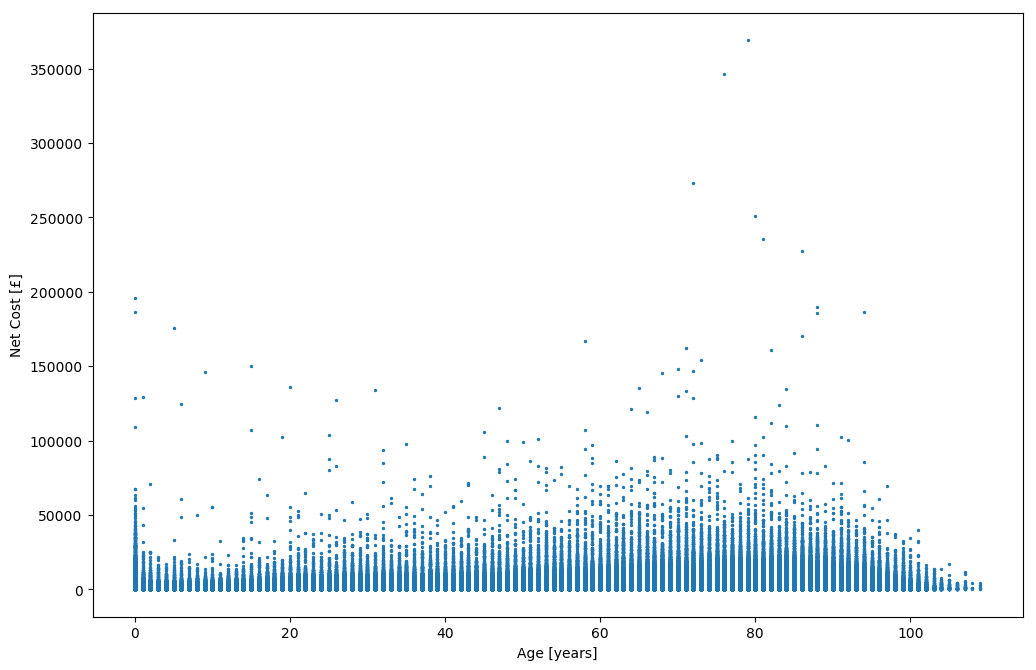

In [24]:
plt.figure(figsize=(12,8), dpi=100)
plt.scatter(df.Age, df.NetCost, s=2)
plt.xlabel('Age [years]')
plt.ylabel('Net Cost [£]');

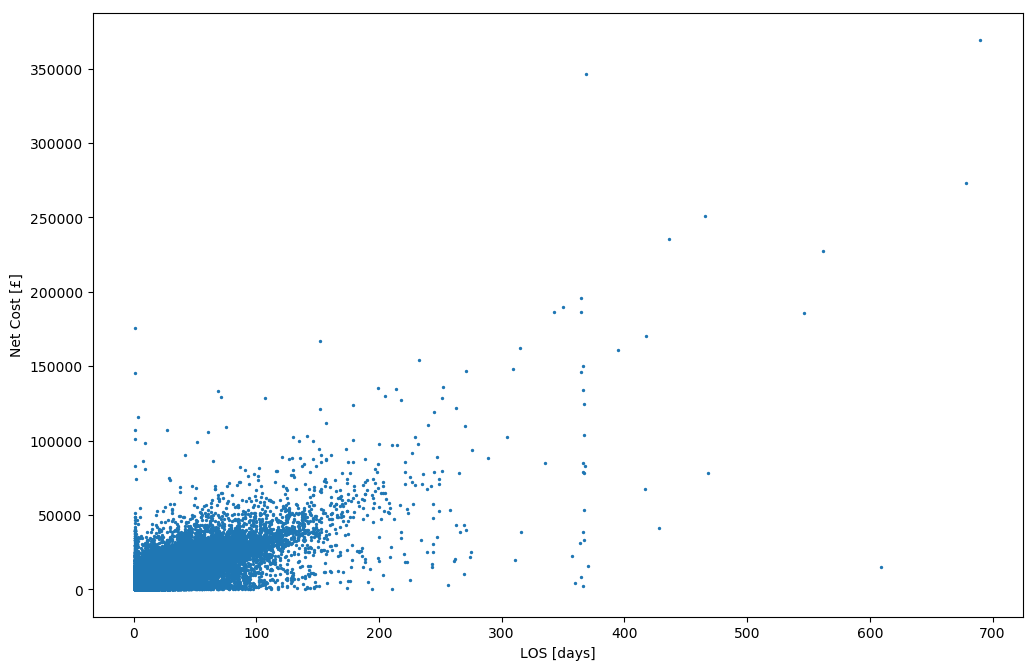

In [20]:
plt.figure(figsize=(12,8), dpi=100)
plt.scatter(df[df.LOS < 3500].LOS, df[df.LOS < 3500].NetCost, s=2)
plt.xlabel('LOS [days]')
plt.ylabel('Net Cost [£]');

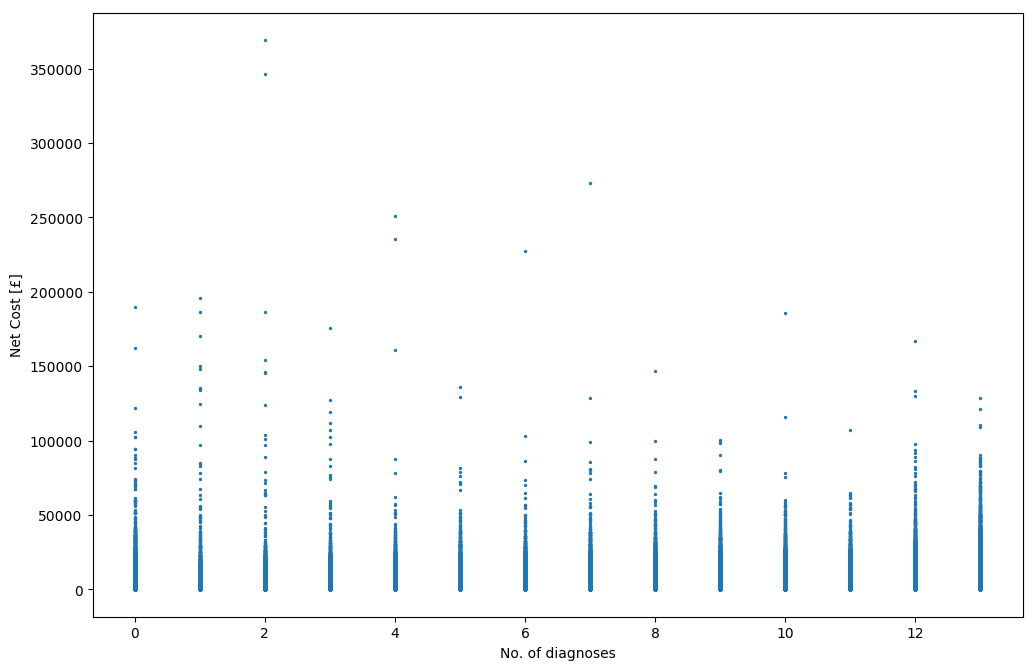

In [17]:
plt.figure(figsize=(12,8), dpi=100)
plt.scatter(df.DIAG_NO, df.NetCost, s=2)
plt.xlabel('No. of diagnoses')
plt.ylabel('Net Cost [£]');

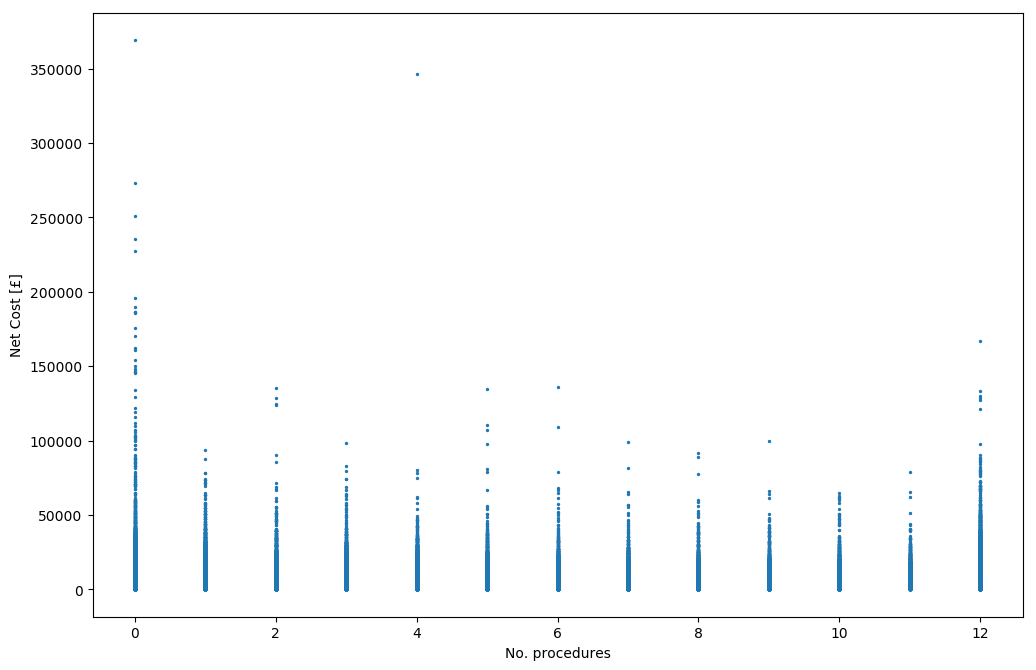

In [18]:
plt.figure(figsize=(12,8), dpi=100)
plt.scatter(df.PROC_NO, df.NetCost, s=2)
plt.xlabel('No. procedures')
plt.ylabel('Net Cost [£]');